<img src="BC_logotipo.png" style="width:180px;height:50px"> 
<h3><p style="color:gold">Seleccionador de Variables para modelos analiticos</p></h3>

In [1]:
# pd.set_option('display.max_rows', 100)
import sys
import time
import os
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import random
import lightgbm as lgb
import xgboost as xgb
from random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from helper.helper import Helper
import matplotlib.pyplot as plt
import seleccionador as sel # Script que te pasé
import importlib
importlib.reload(sel)

<module 'seleccionador' from 'd:\\mgaviria\\Documents\\Documentos\\Plantillas\\Seleccion de variables\\venv\\Seleccion de variables V201\\seleccionador.py'>

In [2]:
ih = Helper(dsn="impala-prod")

2022-02-03 16:16:10 - [WARNING] - No se encontro la carpeta "d:\mgaviria\Documents\Documentos\Plantillas\Seleccion de variables\venv\Seleccion de variables V201\logs" para guardar los logs


 ___ __  __ ____   _    _        _    
|_ _|  \/  |  _ \ / \  | |      / \   
 | || |\/| | |_) / _ \ | |     / _ \  
 | || |  | |  __/ ___ \| |___ / ___ \ 
|___|_|  |_|_| /_/   \_\_____/_/   \_\
                                      
 _   _ _____ _     ____  _____ ____  
| | | | ____| |   |  _ \| ____|  _ \ 
| |_| |  _| | |   | |_) |  _| | |_) |
|  _  | |___| |___|  __/| |___|  _ < 
|_| |_|_____|_____|_|   |_____|_| \_\
                                     



<h1> <p style="color:gold">Cargar el Dataset</p></h1>

In [3]:
# CARGA BASE
base_train = ih.obtener_dataframe("""
                                  select * from resultados_bam_vpr.cob_propen_16005_base_modelacion
                                  """)

base_train_sample = base_train.sample(100000)
# base_train_sample = base_train

# base_train_sample = base_train_sample.apply(pd.to_numeric, errors='ignore', axis=1)

------------------------------------------------------------
  i    tipo    nombre    estado     hora_inicio   duracion   
------------------------------------------------------------
 1/1 DATAFRAME       convirtiendo   04:16:12 PM             

2022-02-03 16:19:30 - [INFO] - 663,070 filas, 36 columnas, 00:00.3 consultando, 03:11.9 descargando, 00:06.0 convirtiendo


 1/1 DATAFRAME         finalizado   04:16:12 PM     03:18.6 
------------------------------------------------------------


In [4]:
# base_train_sample = base_train_sample.fillna(base_train_sample.mean())
base_train_sample.isna().sum()

fa                                               0
fecha_proceso                                    0
id_obligacion                                    0
id_cliente                                       0
var_resp                                         0
grupo_homogeneo                                  0
atm_oblig                                        0
madurez                                          0
base                                             0
cobro_cnt_promesas_cumplidas_fa                  0
cobro_cnt_promesas_totales_fa                    0
cobro_cnt_promesas_totales_ult_6m                0
cobro_cnt_contactos_alternos_fa                  0
cobro_cnt_contactos_alternos_6m                  0
cobro_cnt_gestion_directa_con_contacto_fa        0
cobro_cnt_gestion_virtual_fa                     0
cobro_cnt_convenio_verbal_ultimos_fa             0
cobro_cnt_gestion_3m                             0
prodact_por_mnt_pagado                       31518
prodact_pr_tot_cnt_vigte       

In [5]:
print(base_train_sample.shape)
base_train_sample.head(10)

(100000, 36)


,fa,fecha_proceso,id_obligacion,id_cliente,var_resp,grupo_homogeneo,atm_oblig,madurez,base,cobro_cnt_promesas_cumplidas_fa,...,ctrlint_max_madurez_cli,trx_tc_consumo_mnt_sum_fa,trx_tc_consumo_trx_cnt_fa,trx_tc_abono_mnt_sum_fa,trx_tc_abono_mnt_sum_ult_6m,trx_tc_abono_trx_cnt_fa,trx_tc_abono_trx_cnt_ult_3m,ingestion_day,ingestion_month,ingestion_year
248415,202001,2020-01-31,4894837000944682,1900804,0,TC,1,85,Oot,0,...,85,68.19,8.0,0.00,441.03,0.0,3.0,31,1,2020
338893,201801,2018-01-31,4218377000619322,2117526,0,TC,7,37,Train,0,...,37,-999.00,-999.0,-999.00,-999.00,-999.0,-999.0,31,1,2018
282591,201909,2019-09-30,10981407,640482,1,CF,1,42,Oot,2,...,42,NaN,NaN,NaN,NaN,NaN,NaN,30,9,2019
445344,201907,2019-07-31,4218377001107459,1100184,0,TC,1,15,Train,0,...,87,52.47,7.0,0.00,372.58,0.0,1.0,31,7,2019
347530,201805,2018-05-31,4218377000799488,2044360,1,TC,7,16,Train,0,...,16,-999.00,-999.0,-999.00,-999.00,-999.0,-999.0,31,5,2018
647045,201812,2018-12-31,4894837000920724,1952951,1,TC,7,72,Train,0,...,72,-999.00,-999.0,-999.00,-999.00,-999.0,-999.0,31,12,2018
639559,201808,2018-08-31,4218377001126830,2379523,0,TC,1,4,Train,0,...,4,36.69,6.0,0.00,60.12,0.0,1.0,31,8,2018
408588,201905,2019-05-31,4218377001102773,2371867,0,TC,4,13,Train,0,...,13,38.72,1.0,64.74,100.93,1.0,1.0,31,5,2019
24923,201909,2019-09-30,4218377001215245,2400508,1,TC,1,14,Oot,0,...,14,102.16,12.0,129.27,557.64,1.0,2.0,30,9,2019
111537,201811,2018-11-30,4218377000888901,2317828,1,TC,2,16,Test,0,...,16,58.39,8.0,0.00,421.34,0.0,1.0,30,11,2018


In [6]:
base_train_sample = base_train_sample.fillna(base_train_sample.mean())

C:\Users\mgaviria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\mgaviria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [7]:
### Listas de covariables NO cualitativas y variable respuesta

feats_todas = base_train_sample.drop(columns=["grupo_homogeneo","base"]).columns.to_list()[5:31] # lista de solo covariables
#feats_todas = base_train_sample.columns.to_list()[2:]
target = ["var_resp"] # variable respuesta

# 
X_base_con_imputaciones = base_train_sample[feats_todas] # DataFrame con las covariables
y_base_con_imputaciones = base_train_sample[target] # DataFrame con la variable respuesta

<h3><p style="color:gold">Seleccion de variables <b>Arboles</b> y <b>Regresión Ridge</b></p></h3>

In [8]:
# selección de variables usando RF y ridge. 
# base con las variables explicativas
# base con la y
# numero de iteraciones de arboles
# Ruido = 1 genera la base con los ruidos uniforme y normal 
res_sel_features = sel.mejores_variables_rf(X_base_con_imputaciones,
                                        np.ravel(y_base_con_imputaciones),
                                        2, ruidos = 1, ridge_flag = 1, folds=3, seed = 42, type = "class")

d:\mgaviria\Documents\Documentos\Plantillas\Seleccion de variables\venv\Seleccion de variables V201\seleccionador.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["random_normal"] = np.random.normal(0, 1, size=(X.shape[0]))
d:\mgaviria\Documents\Documentos\Plantillas\Seleccion de variables\venv\Seleccion de variables V201\seleccionador.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["random_uniforme"] = np.random.uniform(0, 1, size=(X.shape[0]))


--- Preparando tablas para el modelamiento ... ---
    0:00:00.007262 runtime 
--- RandomForest - Seleccionando y entrenando el mejor modelo con GridSearchCV ... ---
0
rn:5
0
    0:00:00 runtime 
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .............max_depth=5, n_estimators=5, n_jobs=-1; total time=   4.6s
[CV] END .............max_depth=5, n_estimators=5, n_jobs=-1; total time=   0.3s
[CV] END .............max_depth=5, n_estimators=5, n_jobs=-1; total time=   0.3s
[CV] END ............max_depth=5, n_estimators=10, n_jobs=-1; total time=   0.4s
[CV] END ............max_depth=5, n_estimators=10, n_jobs=-1; total time=   0.4s
[CV] END ............max_depth=5, n_estimators=10, n_jobs=-1; total time=   0.4s
    0:00:07.415530 runtime 
1
rn:25
1
    0:00:07.415727 runtime 
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ............max_depth=25, n_estimators=5, n_jobs=-1; total time=   0.5s
[CV] END ............max_depth=25, n_estimators=5, n_

In [9]:
res_sel_features

,variable,importancia_rf_0,rank_rf_0,importancia,importancia_rf_1,rank_rf_1,importancia_ridge,rank_ridge
5,ctrlint_max_madurez_cli,0.058373,23.0,73.0,0.064264,25.0,0.149767,25.0
4,ctrlint_dif_atm_avg_atm_ult_6m,0.094705,24.0,68.0,0.041166,17.0,8.164106,27.0
9,cobro_cnt_contactos_alternos_6m,0.023542,19.0,64.0,0.052766,22.0,0.029039,23.0
8,trx_tc_abono_trx_cnt_ult_3m,0.028353,20.0,57.0,0.021381,9.0,27.237389,28.0
3,ctrlint_avg_atm_ult_6m,0.127496,25.0,55.0,0.069337,26.0,-3.396489,4.0
14,trx_tc_consumo_mnt_sum_fa,0.005817,14.0,54.0,0.045356,20.0,0.021680,20.0
7,madurez,0.042557,21.0,54.0,0.060829,23.0,-0.036203,10.0
0,ctrlint_std_atm_ult_3m,0.177701,28.0,52.0,0.027362,12.0,-0.005851,12.0
1,ctrlint_std_atm_ult_6m,0.159298,27.0,51.0,0.049816,21.0,-4.750753,3.0
2,atm_oblig,0.157074,26.0,51.0,0.044051,18.0,-0.104179,7.0


<h3><p style="color:gold"> Seleccion de variables <b>Boruta</b></p></h3>

In [10]:
boruta_vars = sel.Boruta(X_base_con_imputaciones,y_base_con_imputaciones, type = "class")

C:\Users\mgaviria\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mgaviria\AppData\Local\Programs\Python\Python37\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
C:\Users\mgaviria\AppData\Local\Programs\Python\Python37\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
C:\Users\mgaviria\AppData\Local\Programs\Python\Python37\lib\site-packages\boruta\boruta_py.py:384: DataConversionWarning: A column-vector 

In [11]:
### Variables escogidas, débiles, y desechadas por Boruta
print(boruta_vars.vars_aceptadas)
print(boruta_vars.vars_debiles)
print(boruta_vars.vars_basura)

['atm_oblig', 'madurez', 'cobro_cnt_promesas_cumplidas_fa', 'cobro_cnt_promesas_totales_fa', 'cobro_cnt_promesas_totales_ult_6m', 'cobro_cnt_contactos_alternos_fa', 'cobro_cnt_contactos_alternos_6m', 'cobro_cnt_gestion_directa_con_contacto_fa', 'cobro_cnt_gestion_virtual_fa', 'cobro_cnt_gestion_3m', 'prodact_por_mnt_pagado', 'prodact_pr_tot_cnt_vigte', 'prodact_pr_tot_desemb_ult_6m', 'ctrlint_avg_atm_ult_6m', 'ctrlint_dif_atm_avg_atm_ult_6m', 'ctrlint_std_atm_ult_3m', 'ctrlint_std_atm_ult_6m', 'ctrlint_cont_oblig_en_mora_cli', 'ctrlint_max_madurez_cli', 'trx_tc_consumo_mnt_sum_fa', 'trx_tc_consumo_trx_cnt_fa', 'trx_tc_abono_mnt_sum_fa', 'trx_tc_abono_mnt_sum_ult_6m', 'trx_tc_abono_trx_cnt_fa', 'trx_tc_abono_trx_cnt_ult_3m']
[]
['cobro_cnt_convenio_verbal_ultimos_fa', 'random_normal', 'random_uniforme']


<h3><p style="color:gold"> Information Value (Solo para problemas de <b>Clasificacion</b>)</p></h3>

In [12]:
sel.iv_woe(base_train_sample,"var_resp",bins=10, show_woe=False)

IV de la variable fa es: 0.004204
IV de la variable fecha_proceso es: 0.013553
IV de la variable id_obligacion es: 0.061529
IV de la variable id_cliente es: 0.051038
IV de la variable grupo_homogeneo es: 0.014218
IV de la variable atm_oblig es: 0.35277
IV de la variable madurez es: 0.074595
IV de la variable base es: 0.000982
IV de la variable cobro_cnt_promesas_cumplidas_fa es: 0.0
IV de la variable cobro_cnt_promesas_totales_fa es: 0.005896
IV de la variable cobro_cnt_promesas_totales_ult_6m es: 0.009938
IV de la variable cobro_cnt_contactos_alternos_fa es: 0.030637
IV de la variable cobro_cnt_contactos_alternos_6m es: 0.05075
IV de la variable cobro_cnt_gestion_directa_con_contacto_fa es: 0.002798
IV de la variable cobro_cnt_gestion_virtual_fa es: 0.00183
IV de la variable cobro_cnt_convenio_verbal_ultimos_fa es: 0.0
IV de la variable cobro_cnt_gestion_3m es: 0.049088
IV de la variable prodact_por_mnt_pagado es: 0.019016
IV de la variable prodact_pr_tot_cnt_vigte es: 0.004891
IV de 

(                                    Variable        IV
 0                                         fa  0.004204
 0                              fecha_proceso  0.013553
 0                              id_obligacion  0.061529
 0                                 id_cliente  0.051038
 0                            grupo_homogeneo  0.014218
 0                                  atm_oblig  0.352770
 0                                    madurez  0.074595
 0                                       base  0.000982
 0            cobro_cnt_promesas_cumplidas_fa  0.000000
 0              cobro_cnt_promesas_totales_fa  0.005896
 0          cobro_cnt_promesas_totales_ult_6m  0.009938
 0            cobro_cnt_contactos_alternos_fa  0.030637
 0            cobro_cnt_contactos_alternos_6m  0.050750
 0  cobro_cnt_gestion_directa_con_contacto_fa  0.002798
 0               cobro_cnt_gestion_virtual_fa  0.001830
 0       cobro_cnt_convenio_verbal_ultimos_fa  0.000000
 0                       cobro_cnt_gestion_3m  0

<h3><p style="color:gold"> Seleccion de Variables por <b>Correlacion</b> </p></h3>

In [13]:
# en la lista de variables_categoricas se debe poner el nombre de las variables categoricas, como las marcas por ejemplo
nombre_iteracion = 'iteracion1'
variables_categoricas = []
# poner acá la base sin imputaciones. base_sin_imputaciones debe tener la base con todas las variables explicativas sin imputar
base_sin_imputaciones = base_train_sample[feats_todas]
#base_sin_imputaciones=base_train

--- Calculando correlaciones ---
Escribiendo reporte...


<Figure size 792x720 with 0 Axes>

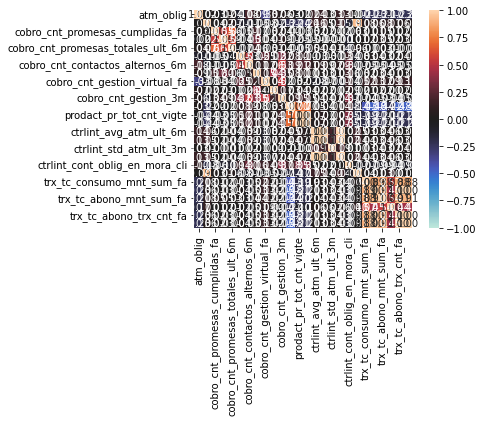

In [14]:
# Ejecuta correlaciones. Busca correlaciones dependiendo el tipo de variable (si es continua o categorica)
# Este proceso se hace con la base sin imputaciones
plt.figure(figsize=(11, 10))
corr_par = sel.correlaciones_parejas( nombre_iteracion, base_sin_imputaciones, variables_categoricas)

In [15]:
# Se corre el proceso que toma el listado de las variables rankeadas y la matriz de correlacion y arroja un df con las 
# variables a eliminar
varsalen = sel.depuracion_vars_correlacionadas_corr( nombre_iteracion, corr_par, res_sel_features )
# definicion final de las variables con las cuales empezará el entrenamiento

Iteracion 2
Iteracion 3
Iteracion 4
                       variable  ronda
0                       madurez      1
1       trx_tc_abono_trx_cnt_fa      1
2  prodact_pr_tot_desemb_ult_6m      1
3        ctrlint_std_atm_ult_6m      1
0        ctrlint_avg_atm_ult_6m      2
1     trx_tc_consumo_trx_cnt_fa      2
0       trx_tc_abono_mnt_sum_fa      3
0     trx_tc_consumo_mnt_sum_fa      4


In [16]:
# finalmente, se itera sobre las variables de la base para descartar las variables que se obtuvieron arriba
feats_train = [e for e in base_sin_imputaciones.columns if e not in  list(varsalen['variable'])]
feats_train = list(set(feats_train))

In [17]:
# variables finales con las que se inicia el proceso de entrenamiento
feats_train

['ctrlint_dif_atm_avg_atm_ult_6m',
 'cobro_cnt_promesas_cumplidas_fa',
 'prodact_pr_tot_cnt_vigte',
 'ctrlint_cont_oblig_en_mora_cli',
 'atm_oblig',
 'ctrlint_max_madurez_cli',
 'cobro_cnt_gestion_3m',
 'trx_tc_abono_mnt_sum_ult_6m',
 'prodact_por_mnt_pagado',
 'ctrlint_std_atm_ult_3m',
 'cobro_cnt_promesas_totales_ult_6m',
 'cobro_cnt_promesas_totales_fa',
 'cobro_cnt_contactos_alternos_6m',
 'cobro_cnt_convenio_verbal_ultimos_fa',
 'trx_tc_abono_trx_cnt_ult_3m',
 'cobro_cnt_gestion_virtual_fa',
 'cobro_cnt_gestion_directa_con_contacto_fa',
 'cobro_cnt_contactos_alternos_fa']